# Filtering, Smoothing and Denoising

In this tutorial, we show how to filter/smooth 1D and 2D spectra and gives information
on the algorithms used in Spectrochempy.

We first import spectrochempy, the other libraries used in this tutorial, and a sample
raman dataset:

In [1]:
import spectrochempy as scp
from spectrochempy import info_

Running on GitHub Actions
MPL Configuration directory: /home/runner/.config/matplotlib
Stylelib directory: /home/runner/.config/matplotlib/stylelib


First, we import a sample raman spectrum:

In [2]:
# use the generic read function. Note that read_labspec would be equivalent for this file format.
X = scp.read("ramandata/labspec/SMC1-Initial_RT.txt")

and plot it:

<Matplotlib Axes object>

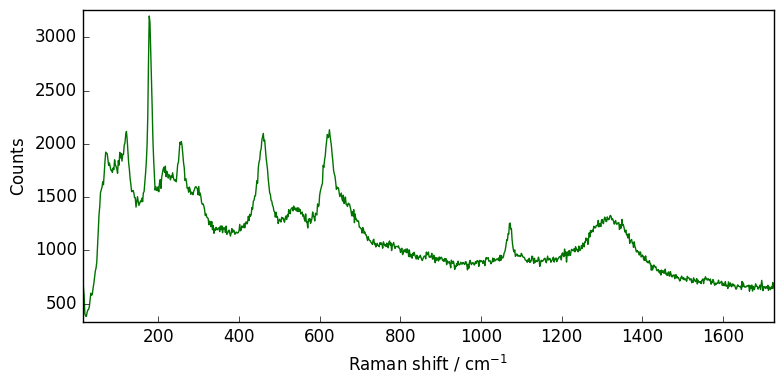

In [3]:
# Use preferences to set the figure size for all figures
prefs = scp.preferences
prefs.figure.figsize = (8, 4)

# and use plot method of the NDDataset
X.plot()

To have a better view of the filters effect, we will zoom on a smaller region:
(0,400) cm$^{-1}$ and we will add some additional noise.

 This coordinate (0.0) is outside the axis limits (12.553-1726.5).
The closest limit index is returned


 shape: (1, 1024)


<Matplotlib Axes object>

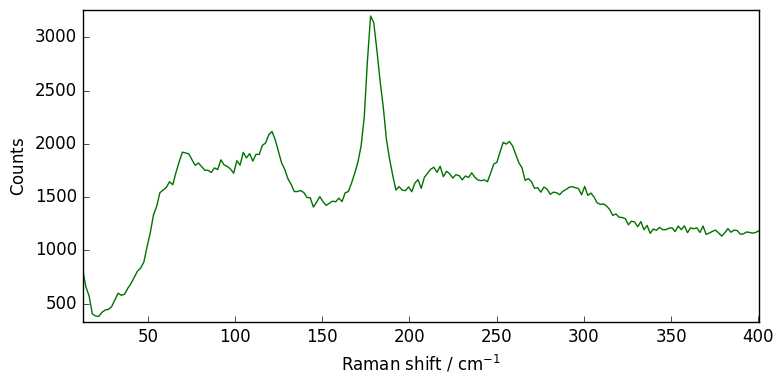

In [4]:
# select a region by slicing (note the original shape is (1, 1024)
Xs = X[:, 0.0:400.0]
info_(f"shape: {X.shape}")
Xs.plot()

<Matplotlib Axes object>

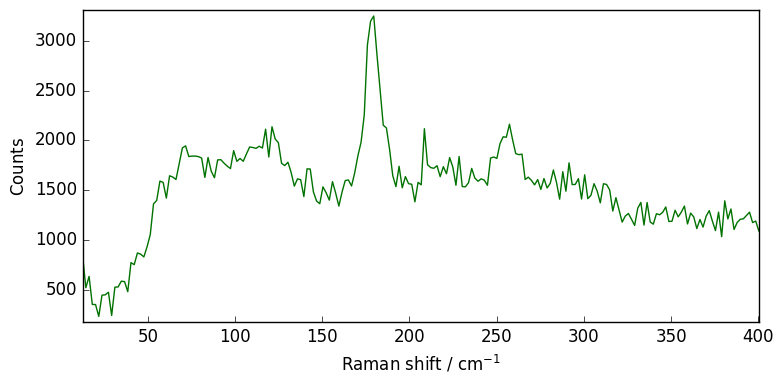

In [5]:
import numpy as np

noise = np.random.normal(0, 100, 215)
Xn = Xs + noise
Xn.plot()

## The `Filter` processor

The `Filter` processor is a generic processor which can be used to filter 1D and 2D
spectra.

Here is a demonstration on how to use it to smooth a 1D spectrum.

### Moving average

In its simplest form of smoothing is a unweighted moving average - each absorbance at
a given wavenumber of the smoothed spectrum is the average of the absorbance at the
absorbance at the considered wavenumber and the N neighboring wavenumbers
(i.e. N/2 before and N/2 after), hence the conventional use of an odd number of
N+1 points to define the window length. For the points located at both end of the
spectra, the extremities of the spectrum are mirrored beyond the initial limits to
minimize boundary effects.


Let's create a filter processor with a moving average (method `avg`) of 3 points
(default size is 5).

In [6]:
filter = scp.Filter(method="avg", size=5)

Apply the filter to the spectrum Xn

In [7]:
Xsm = filter.transform(Xn)

Note that the above syntax can be simplified to the equivalent:

In [8]:
Xsm = filter(Xn)

Now, let's plot the result.

However, as this will be repeated along the tutorial, we first make a function to plot
both original and transformed spectra on the same figure, with a legend.

In [9]:
def plot(X, Xm, label=None, xlim=None):
    X.plot(color="b", label="original")
    ax = Xm.plot(clear=False, color="r", ls="-", lw=1.5, label=label)
    diff = X - Xm
    s = round(diff.std(dim=-1).values, 2)
    ax = diff.plot(clear=False, ls="-", lw=1, label=f"difference (std={s})")
    ax.legend(loc="best", fontsize=10)
    if xlim is not None:
        ax.set_xlim(xlim)
    # scp.show()

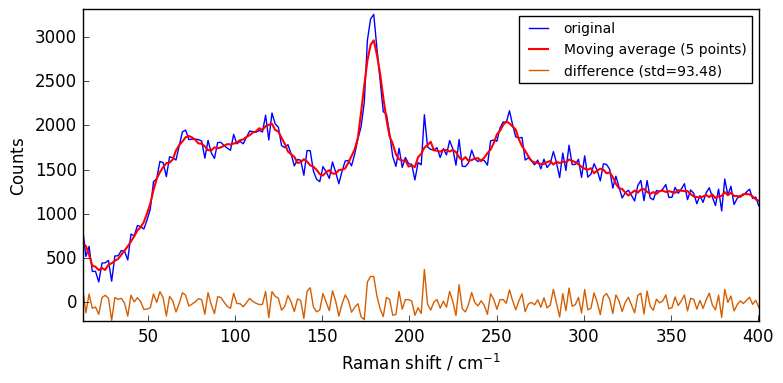

In [10]:
plot(Xn, Xsm, label="Moving average (5 points)")

### Convolution with window filters

These filters are based on the convolution of scaled window, with the signal.
For instance the `han` convolution method use a `han` (also known as 'hanning')
window.

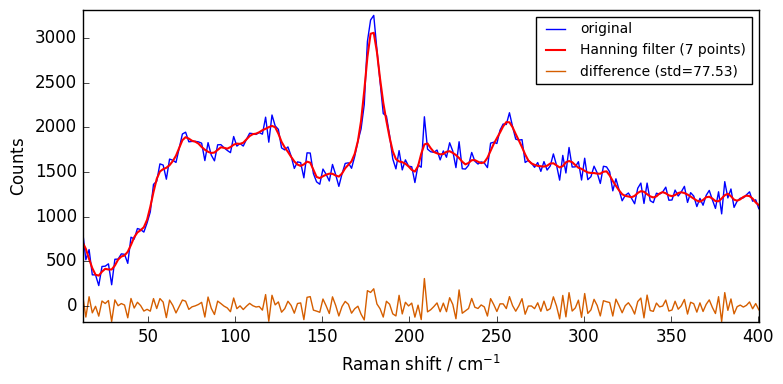

In [11]:
filter = scp.Filter(
    method="han", size=7
)  # can also be one of 'hamming', 'bartlett', # 'blackman'.
Xhan = filter(Xn)
plot(Xn, Xhan, label="Hanning filter (7 points)")

### Savitzky-Golay filter

The `Filter` processor can also be used to apply a Savitzky-Golay filter to the
spectrum.

This algorithm uses a polynomial interpolation in the moving window. A demonstrative
illustration of the method can be found on the Savitzky-Golay filter entry of
Wikipedia.

The function implemented in spectrochempy is a wrapper of the savgol_filter() method
from the scipy.signal module to which we refer the interested reader. It not only
used to smooth spectra but also to compute their successive derivatives. The latter
are treated in the peak-finding tutorial and we will focus here on the smoothing
which is the default of the filter (default parameter: deriv=0 ).

As for the previous kernel-based filters, it is a moving-window based method. Hence,
the window length (`size` parameter) plays an equivalent role. Moreover,
instead of choosing a window function, the user can choose the order of the
polynomial used to fit the window data points (`order` , default value: 0).
The latter must be strictly smaller than the window size (so that the polynomial
coefficients can be fully determined).

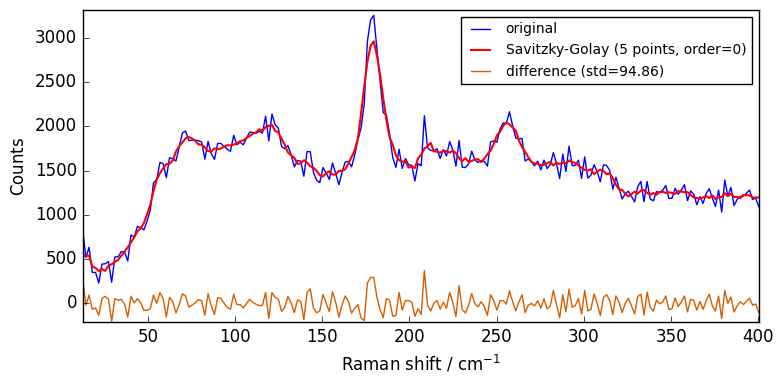

In [12]:
filter = scp.Filter(
    method="savgol", size=5, order=0
)  # default is size=5, order=2, deriv=0
Xsgs = filter(Xn)
plot(Xn, Xsgs, label="Savitzky-Golay (5 points, order=0)")

As the `order` is set to 0, there is no much difference compared to a simple moving
average.

Now we can try to increase the polynomial order to 2 to see the effect on the
smoothing.

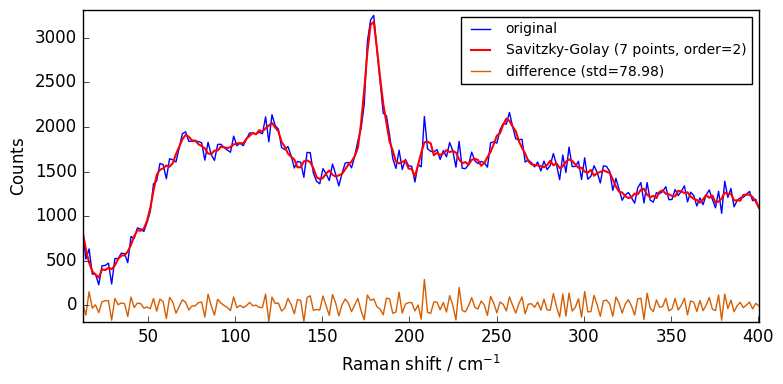

In [13]:
filter.order = 2
filter.size = 7
Xsm2 = filter(Xn)
plot(Xn, Xsm2, label="Savitzky-Golay (7 points, order=2)")

### Whittaker-Eilers filter

As good alternative to the Savitzky-Golay filter want can choose to use the
Whittaker-Eilers smoother described in:
P. H. C. Eilers, "A perfect smoother", Anal. Chem. 2003, 75, 3631-3636.
The implementation in SpectroChemPy is based on the work by H. V. Werts
(https://github.com/mhvwerts/whittaker-eilers-smoother). The main parameter to be
changed is the `lamb` ('λ' in the Eilers paper), which determines the strength
of the smoothing. Note that it may needs tuning over several orders of
magnitude (1, 10, 100, 1000, ...).

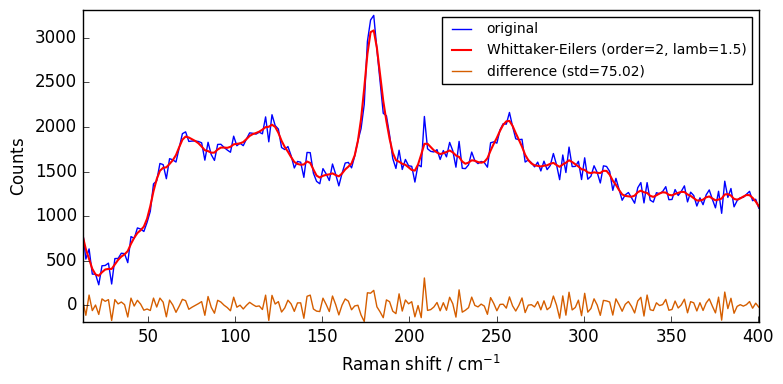

In [14]:
filter = scp.Filter(method="whittaker", order=2, lamb=1.5)
Xwhit = filter(Xn)
plot(Xn, Xwhit, label="Whittaker-Eilers (order=2, lamb=1.5)")

## Filtering using API or NDDataset methods.

In addition to the `Filter` processor which provide an uniform interface to the
various filter methods provided by
SpectroChemPy, it is also possible (as in previous version of spectrochempy)
to use specific NDDataset methods or API functions.

Let's demonstrate this here.

### The `smooth` method

When simply used as this, i.e. `X.smooth()` , the method uses a default
moving average ('avg') of 5 points:

In [15]:
Xsm = Xn.smooth()  # NDDataset method

Note that it is also possible to use the API function `scp.smooth(X)` instead of the
dataset method `X.smooth()`. The result
is the same.

In [16]:
Xsm = scp.smooth(Xn)  # SpectroChemPy API function

#### Window size influence

The following code compares the influence of the window size on the smoothing of
the `Xn` NDDataset.

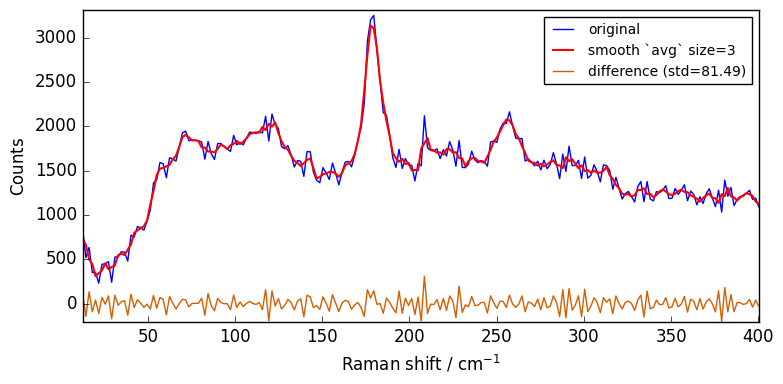

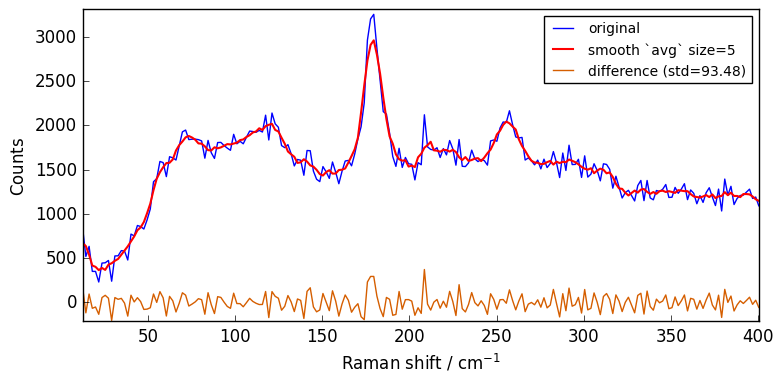

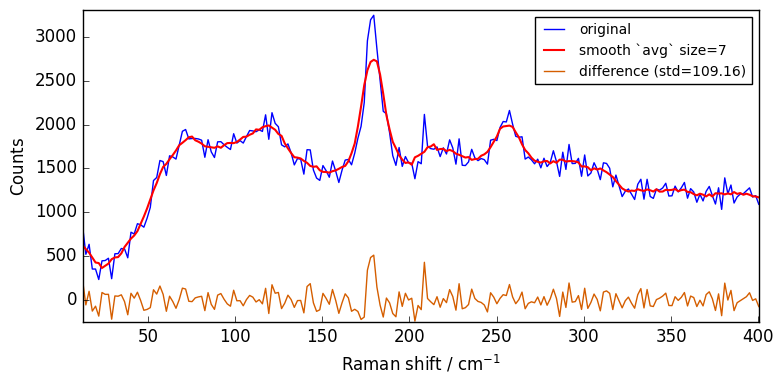

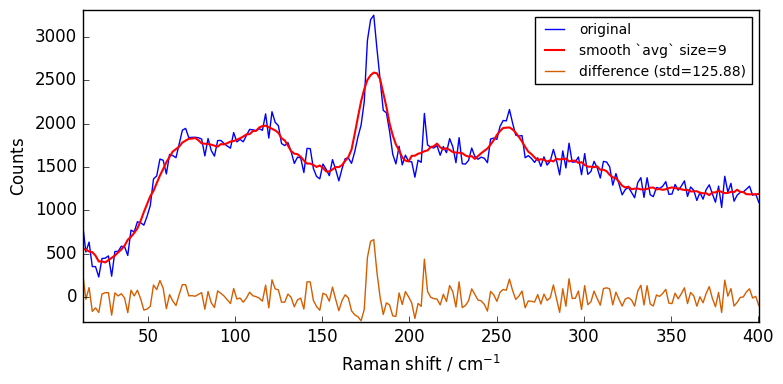

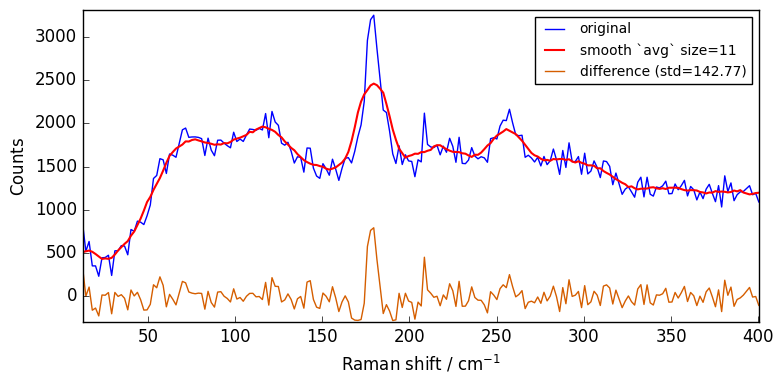

In [17]:
for size in [3, 5, 7, 9, 11]:
    Xsm = Xn.smooth(size)
    plot(Xn, Xsm, label=f"smooth `avg` size={size}")

The above spectra clearly show that for large value of the `size` parameter,
the spectrum is flattened out and distorted.

When determining the optimum window size, one should thus consider
the balance between noise removal and signal integrity: the larger the window size,
the stronger the smoothing,
but also the greater the chance to distort the spectrum.

### Convolution with windows

Besides the window `size`, the user can also choose the type of
window (`window` ) from `flat`(eq. to `avg`) , `han` , `hamming` ,
`bartlett` or `blackman` .
The `flat` window - which is the default shown above - should be fine for the vast
majority of
cases.

The code below compares the effect of the type of window:

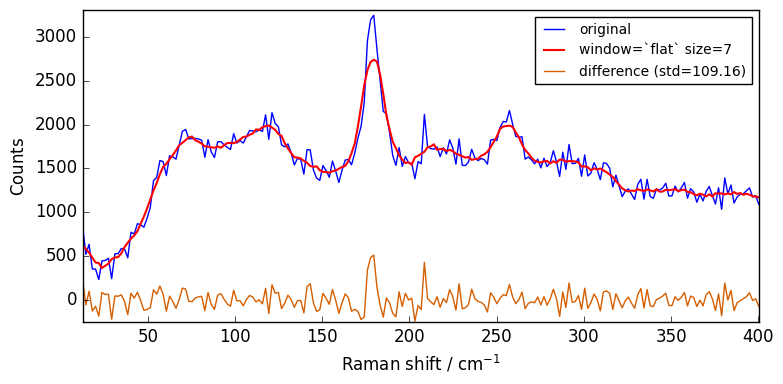

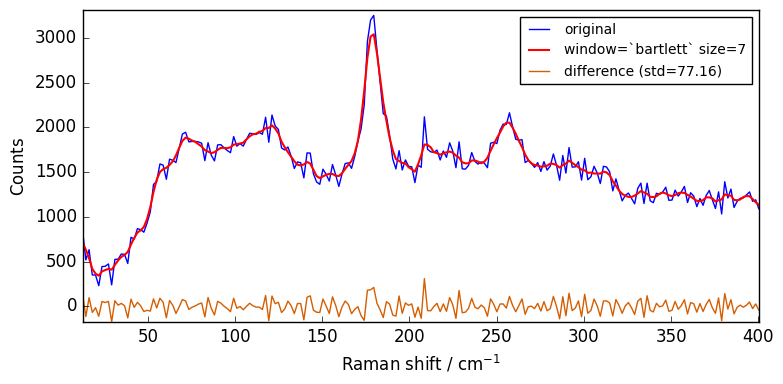

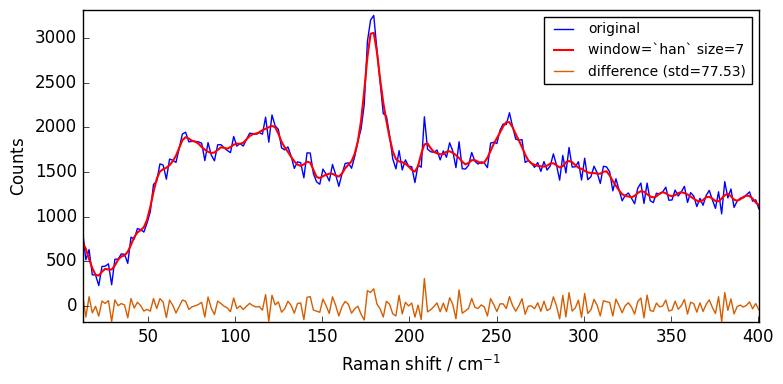

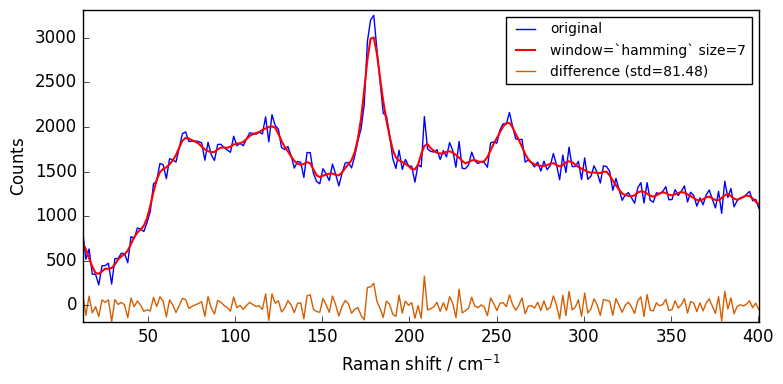

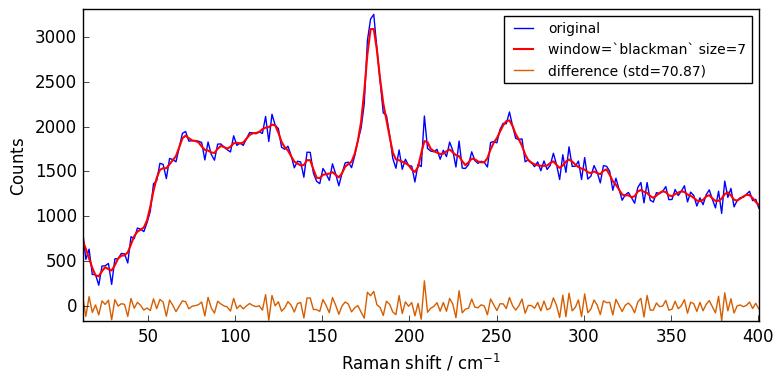

In [18]:
size = 7
for window in ["flat", "bartlett", "han", "hamming", "blackman"]:
    Xsm = Xn.smooth(size=size, window=window)
    plot(Xn, Xsm, label=f"window=`{window}` size={size}")

Close examination of the spectra shows that the flat window leads to the stronger
smoothing. This is
because the other window functions are used as weighting functions for the
N+1 points, with the largest weight on the central point and smaller weights for
external points.

The window functions as used in SpectroChemPy are derived from the scipy library.
These builtin functions are such
that the value of the central point is 1. Hence, as shown below,  they are normalized
to the sum of weights. The
code below displays the corresponding normalized functions for size=27 points:

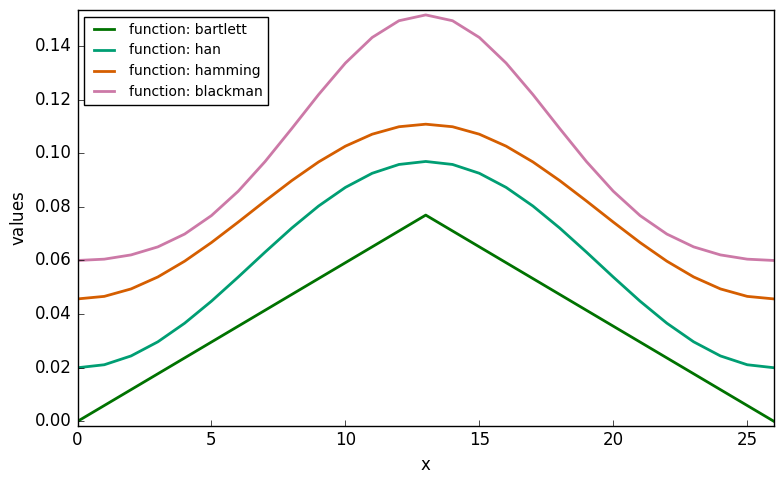

In [19]:
import numpy as np
import scipy

functions = []
labels = []
size = 27
for i, method in enumerate(["bartlett", "han", "hamming", "blackman"]):
    data = scipy.signal.get_window(method, size, fftbins=False)
    data = data / np.sum(data)

    s = scp.NDDataset(
        data + 0.02 * i
    )  # normalized window function, y shifted : +0.1 for each function
    functions.append(s)
    labels.append(f"function: {method}")

ax = scp.plot_multiple(
    figsize=(8, 5),  # ylim=(0,0.1),
    method="pen",
    datasets=functions,
    labels=labels,
    ls="-",
    lw=2,
)
_ = ax.legend(labels, loc="upper left", fontsize=10)

As shown above, the "bartlett" function is equivalent to a triangular window,
while other
functions (`hanning` , `hamming` , `blackman` ) are bell-shaped. More information on
window functions can be found [
here](https://en.wikipedia.org/wiki/Window_function).

### Savitzky-Golay filter:`savgol`
Similarly, the Savitsky-Golay filter is also implemented as an API/NDDataset method:

In [20]:
Xsg = scp.savgol(Xn, size=5, order=2, mode="mirror")

### Whittaker-eilers filter : `whittaker`
Finally, we can also use the `whittaker` filter directly. *e.g*.:

In [21]:
Xw = scp.whittaker(Xn, lamb=10)